In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Dataset overview

In [7]:
import pandas as pd

# Download and load the dataset
url = "https://raw.githubusercontent.com/GuviMentor88/Training-Datasets/refs/heads/main/twitter_training.csv"
df = pd.read_csv(url)

# Display the first few rows
print(df.head())


   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [8]:
df.shape


(74681, 4)

In [9]:
# Assigning column names
df.columns = ['Tweet_id', 'Location', 'Review', 'Tweets']
print(df)

       Tweet_id     Location    Review  \
0          2401  Borderlands  Positive   
1          2401  Borderlands  Positive   
2          2401  Borderlands  Positive   
3          2401  Borderlands  Positive   
4          2401  Borderlands  Positive   
...         ...          ...       ...   
74676      9200       Nvidia  Positive   
74677      9200       Nvidia  Positive   
74678      9200       Nvidia  Positive   
74679      9200       Nvidia  Positive   
74680      9200       Nvidia  Positive   

                                                  Tweets  
0      I am coming to the borders and I will kill you...  
1      im getting on borderlands and i will kill you ...  
2      im coming on borderlands and i will murder you...  
3      im getting on borderlands 2 and i will murder ...  
4      im getting into borderlands and i can murder y...  
...                                                  ...  
74676  Just realized that the Windows partition of my...  
74677  Just realized th

In [10]:
#duplicate
df.duplicated().sum()

2700

In [11]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [12]:
df.drop(columns=['Tweet_id', 'Location'], inplace=True)

In [13]:
# Replace "Irrelevant" with "Neutral"
df['Review'] = df['Review'].replace('Irrelevant', 'Neutral')

# Label Encoding
sentiment_mapping = {'Positive': 1, 'Negative': 2, 'Neutral': 0}
df['Review'] = df['Review'].map(sentiment_mapping)

# Data Cleaning

In [14]:
df.columns

Index(['Review', 'Tweets'], dtype='object')

In [9]:
df["Location"].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [10]:
print(f"Before removal: {df.shape}")
print(df["Tweets"].isnull().sum())
df = df.dropna(subset=["Tweets"])
print(f"After removal: {df.shape}")


Before removal: (71655, 4)
0
After removal: (71655, 4)


In [15]:
df.isnull().sum()

,0
Review,0
Tweets,0


In [12]:
# # Function to clean text
# def clean_text(text):
#     """
#     Cleans text by removing URLs, special characters, and extra whitespaces.
#     """
#     text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
#     text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
#     text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
#     return text

# # Preprocess dataset
# def preprocess_data(df):
#     """
#     Cleans and preprocesses the dataset.
#     """
#     df = df.dropna(subset=["Tweets"])  # Remove rows with missing text
#     df["text"] = df["Tweets"].apply(clean_text)  # Clean text
#     df["Reviews"] = df["Reviews"].replace('Irrelevant', 'Neutral')  # Combine sentiments
#     df.drop_duplicates(inplace=True)  # Remove duplicates
#     return df

In [13]:
df[:300]

,Tweet_id,Location,Review,Tweets
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
309,2452,Borderlands,Negative,I hate this stupid algorithm
310,2452,Borderlands,Negative,to hate this algorithm
311,2453,Borderlands,Positive,This April patch + mini DLC for Borderlands 3 ...
312,2453,Borderlands,Positive,This April patch + mini DLC for Borderlands 3 ...


In [16]:
df.to_csv("cleaned_dataset.csv", index=False)

In [16]:
# Tokenize and lemmatize text
def lemmatize_texts(texts):
    """
    Tokenizes and lemmatizes texts using SpaCy.
    """
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    lemmatizer = nlp.pipe(texts, batch_size=50, disable=["parser", "ner"])
    return [" ".join([token.lemma_ for token in doc]) for doc in lemmatizer]

**Data visualization**

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-12-11566f83bcb3>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


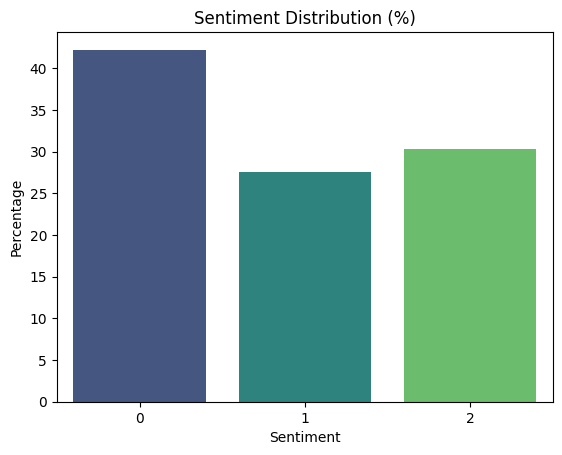

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


# Function to preprocess text
def preprocess_data(df):
    """
    Preprocesses the data: Converts text to lowercase and removes punctuation.
    """
    df["Tweets"] = df["Tweets"].str.lower().str.replace('[^\w\s]', '', regex=True)
    return df

# Function to lemmatize text
def lemmatize_texts(texts):
    """
    Lemmatizes the given list of texts.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    lemmatized_texts = []
    for text in texts:
        tokens = text.split()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        lemmatized_texts.append(" ".join(lemmatized_tokens))

    return lemmatized_texts

# Function to plot sentiment distribution
def plot_sentiment_distribution(df):
    """
    Plots the distribution of sentiments in the dataset.
    """
    sentiment_counts = df["Review"].value_counts(normalize=True) * 100
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
    plt.title("Sentiment Distribution (%)")
    plt.xlabel("Sentiment")
    plt.ylabel("Percentage")
    plt.show()

# Function to generate word cloud
def generate_wordcloud(texts, title):
    """
    Generates a word cloud for the given texts.
    """
    cloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(" ".join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(cloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Main workflow
df_clean = preprocess_data(df)  # Preprocess the data
df_clean["lemmatized_text"] = lemmatize_texts(df_clean["Tweets"])  # Lemmatize the Tweets column

# Visualizations
plot_sentiment_distribution(df_clean)  # Plot sentiment distribution
generate_wordcloud(df_clean["lemmatized_text"], "Word Cloud for Tweets")  # Generate word cloud


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_clean is your dataset
sns.catplot(
    data=df,  # Ensure you're using the correct dataset
    x="Location",
    hue="Review",  # Use hue to categorize sentiments
    kind="count",  # Use "count" to count occurrences of each sentiment
    palette="viridis"
)
plt.title("Sentiment by Entity (Location)")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()


ValueError: Could not interpret value `Location` for `x`. An entry with this name does not appear in `data`.

In [17]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [18]:
!pip install torch transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [19]:
import torch
torch.cuda.is_available()


True

**Traing the dataset**

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
from datasets import Dataset
import pandas as pd

In [31]:
import os
os.environ["WANDB_DISABLED"] = "true"


Training and Saving   

**Purpose: Train the model, evaluate its performance, and save the fine-tuned model and tokenizer.**


In [35]:
import torch
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Tweets'], df['Review'], test_size=0.2, random_state=42
)

# Convert to Dataset
train_dataset = Dataset.from_dict({"text": train_texts.astype(str), "label": train_labels})  # Convert Text to numerical
val_dataset = Dataset.from_dict({"text": val_texts.astype(str), "label": val_labels})

# Tokenizer and Tokenization

# Load a pre-trained tokenizer to preprocess text into token IDs and attention masks.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Remove text column
train_dataset = train_dataset.remove_columns(['text'])  # Purpose: Keep only the columns required for model input.
val_dataset = val_dataset.remove_columns(['text'])

# Load the DistilBERT model and move it to the GPU

# Purpose: Load a pre-trained DistilBERT model and set it up for a 3-class classification task (Positive, Negative, Neutral)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3  # Adjust for the number of classes
).to(device)

# Metrics calculation
# Purpose: Calculate evaluation metrics like accuracy, precision, recall, and F1 score.

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits).to(device)  # Ensure logits are on GPU
    labels = torch.tensor(labels).to(device)  # Ensure labels are on GPU
    predictions = torch.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), predictions.cpu(), average='weighted')
    acc = accuracy_score(labels.cpu(), predictions.cpu())
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Training arguments

# Purpose: Define training parameters like batch size, learning rate, and logging.

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Increased for better training
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True  # Enable mixed precision
)

# Trainer
# Purpose: Set up the training and evaluation process.

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train and evaluate
trainer.train()
results = trainer.evaluate()
print("Evaluation Results:", results)


Using device: cuda


Map:   0%|          | 0/57324 [00:00<?, ? examples/s]

Map:   0%|          | 0/14331 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-35-33cbb58eed15>:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.413700,0.441308,0.828274,0.828116,0.828274,0.827995
2,0.182200,0.315093,0.891913,0.894673,0.891913,0.891635
3,0.220900,0.325910,0.914800,0.914822,0.914800,0.914799
4,0.188300,0.346478,0.925127,0.926278,0.925127,0.925014


Evaluation Results: {'eval_loss': 0.3150932490825653, 'eval_accuracy': 0.8919126369408974, 'eval_precision': 0.8946732742978704, 'eval_recall': 0.8919126369408974, 'eval_f1': 0.8916346893049008, 'eval_runtime': 16.6806, 'eval_samples_per_second': 859.142, 'eval_steps_per_second': 53.715, 'epoch': 4.0}


In [36]:
print(f"Model device: {next(model.parameters()).device}")
print(f"Using device: {device}")


Model device: cuda:0
Using device: cuda


In [38]:
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.3150932490825653, 'eval_accuracy': 0.8919126369408974, 'eval_precision': 0.8946732742978704, 'eval_recall': 0.8919126369408974, 'eval_f1': 0.8916346893049008, 'eval_runtime': 24.1297, 'eval_samples_per_second': 593.914, 'eval_steps_per_second': 37.133, 'epoch': 4.0}


In [39]:
# Save model and tokenizer
model.save_pretrained("./fine_tuned_distilbert")

tokenizer.save_pretrained("./fine_tuned_distilbert")

('./fine_tuned_distilbert/tokenizer_config.json',
 './fine_tuned_distilbert/special_tokens_map.json',
 './fine_tuned_distilbert/vocab.txt',
 './fine_tuned_distilbert/added_tokens.json')

**Testing the fine tune Model**

In [41]:
!pip install flask


In [43]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [52]:
import gradio as gr
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn.functional as F
import logging
from datetime import datetime

# Load fine-tuned model and tokenizer
MODEL_PATH = "./fine_tuned_distilbert"  # Adjust to your saved model's path
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Configure logging to store user interactions
LOG_FILE = "user_logs.txt"
logging.basicConfig(
    filename=LOG_FILE,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

def log_user_input(input_text, source="WebApp"):
    """
    Logs user input along with the source (default is 'WebApp').

    Args:
        input_text (str): Text input from the user.
        source (str): Source of input (e.g., "WebApp", "CLI"). Defaults to "WebApp".
    """
    log_entry = f"{datetime.now()} | Source: {source} | Input: {input_text}"
    logging.info(log_entry)


def predict_sentiment(text):
    """
    Predicts sentiment probabilities for the input text.

    Args:
        text (str): Text input for sentiment prediction.

    Returns:
        dict: Probabilities for Negative, Neutral, and Positive sentiments.
    """
    # Log user input
    log_user_input(text)

    # Prepare the input for the model
    inputs = tokenizer(
        text,
        return_tensors="pt",  # PyTorch tensors
        padding="max_length",  # Pad to maximum sequence length
        truncation=True,  # Truncate longer inputs
        max_length=128,  # Maximum length of tokenized input
    )

    # Perform prediction
    with torch.no_grad():  # Disable gradient computation for inference
        outputs = model(**inputs)

    # Compute probabilities using softmax
    probs = F.softmax(outputs.logits, dim=-1)

    # Map probabilities to sentiment labels
    sentiment_probs = {
        "Negative": round(probs[0][2].item(), 4),
        "Neutral": round(probs[0][0].item(), 4),
        "Positive": round(probs[0][1].item(), 4),
    }

    return sentiment_probs


# Define a user-friendly Gradio interface with custom styling and color changes
iface = gr.Interface(
    fn=predict_sentiment,  # Function to call for predictions
    inputs=gr.Textbox(
        lines=2,
        placeholder="Type a tweet or sentence here...",
        label="Enter Text",
        elem_id="input_textbox"  # ID for custom styling
    ),
    outputs=gr.JSON(label="Sentiment Probabilities"),  # Output format
    title="Sentiment Analysis Application",
    description="Analyze text sentiment (Negative, Neutral, Positive) with probabilities.",
    theme="huggingface",  # Huggingface theme for cleaner look
    examples=[  # Predefined examples for quick testing
        "I love this product!",
        "This is the worst service I've ever had.",
        "The weather today is neutral, not too hot or cold.",
    ],
    css="""
    /* Styling for Input Textbox */
    #input_textbox {
        font-size: 16px;
        padding: 15px;
        border-radius: 10px;
        border: 1px solid #4CAF50;  /* Green border */
        width: 80%;
        margin: 0 auto;
        font-family: 'Arial', sans-serif;
        background-color: #f4fdf1;  /* Light green background */
    }

    /* Styling for the entire Gradio container */
    .gradio-container {
        background-color: #f0f8ff;  /* Light blue background */
        border-radius: 15px;
        box-shadow: 0 4px 10px rgba(0, 0, 0, 0.1);
        padding: 20px;
    }

    /* Title Styling */
    .gradio-title {
        color: #2C3E50;  /* Dark gray-blue text color */
        font-family: 'Arial', sans-serif;
        font-size: 28px;
        font-weight: bold;
        text-align: center;
    }

    /* Description Styling */
    .gradio-description {
        font-size: 16px;
        font-family: 'Arial', sans-serif;
        color: #34495E;  /* Darker gray color */
        text-align: center;
    }

    /* Button Styling */
    .gradio-btn {
        background-color: #4CAF50;  /* Green button */
        color: white;
        border-radius: 8px;
        padding: 10px;
        font-size: 14px;
        width: 100%;
        font-family: 'Arial', sans-serif;
        margin-top: 15px;
    }

    /* Button Hover Styling */
    .gradio-btn:hover {
        background-color: #45a049;  /* Slightly darker green on hover */
    }

    /* Output JSON Styling */
    .gradio-json {
        font-size: 16px;
        color: #333;
        background-color: #eaf2f8;  /* Very light blue background */
        padding: 10px;
        border-radius: 8px;
        border: 1px solid #ddd;
    }
    """
)

# Launch the application
iface.launch(share=True)  # Enable sharing via public URL


/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:1048: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-678660ad-5ca3427b389e85216cd06baf;58159db0-1867-4b58-82e9-7c2f3aca3f9b)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6be696e6c403e81d05.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
